In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import keras

import warnings
import seaborn as sns
import cv2
import math

from PIL import Image
from tqdm import tqdm

# GPU 디바이스가 있는지 확인
gpus = tf.config.list_physical_devices('GPU')
if not gpus:
    print("Cannot find GPU. Install tensorflow-gpu and check your gpu driver.")
else:
    for gpu in gpus:
        print("GPU Name:", gpu.name)

# GPU:0을 사용하도록 설정
if gpus:
    tf.config.experimental.set_memory_growth(gpus[0], True)

GPU 이름: /physical_device:GPU:0


In [2]:
warnings.filterwarnings("ignore") # 경고 메세지를 무시

sns.set_context("paper", font_scale=1.4)
# seaborn 라이브러리의 그래프를 논문(paper)에 적합한 크기로 설정, 폰트 크기는 1.4배

id_map = {
    0: np.array([0, 0, 0]), # unlabelled
    1: np.array([111, 74,  0]), #static
    2: np.array([ 81,  0, 81]), #ground
    3: np.array([128, 64,127]), #road
    4: np.array([244, 35,232]), #sidewalk
    5: np.array([250,170,160]), #parking
    6: np.array([230,150,140]), #rail track
    7: np.array([70, 70, 70]), #building
    8: np.array([102,102,156]), #wall
    9: np.array([190,153,153]), #fence
    10: np.array([180,165,180]), #guard rail
    11: np.array([150,100,100]), #bridge
    12: np.array([150,120, 90]), #tunnel
    13: np.array([153,153,153]), #pole
    14: np.array([250,170, 30]), #traffic light
    15: np.array([220,220,  0]), #traffic sign
    16: np.array([107,142, 35]), #vegetation
    17: np.array([152,251,152]), #terrain
    18: np.array([ 70,130,180]), #sky
    19: np.array([220, 20, 60]), #person
    20: np.array([255,  0,  0]), #rider
    21: np.array([  0,  0,142]), #car
    22: np.array([  0,  0, 70]), #truck
    23: np.array([  0, 60,100]), #bus
    24: np.array([  0,  0, 90]), #caravan
    25: np.array([  0,  0,110]), #trailer
    26: np.array([  0, 80,100]), #train
    27: np.array([  0,  0,230]), #motorcycle
    28: np.array([119, 11, 32]), #bicycle
}

# 매칭된 id(즉, 29가지 객체)를 8개의 카테고리로 분류
# 저사양 환경에서 간단하게 분류하고자 할 때 사용 
# 일단 사용 안했음
category_map = {
    0: 0,
    1: 0,
    2: 0,
    3: 1,
    4: 1,
    5: 1,
    6: 1,
    7: 2,
    8: 2,
    9: 2,
    10: 2,
    11: 2,
    12: 2,
    13: 3,
    14: 3,
    15: 3,
    16: 4,
    17: 4,
    18: 5,
    19: 6,
    20: 6,
    21: 7,
    22: 7,
    23: 7,
    24: 7,
    25: 7,
    26: 7,
    27: 7,
    28: 7,
}

num_classes = len(id_map.keys())

print(num_classes)

29


In [3]:
row = 64
col = 64

# 이미지 리사이즈
def img_preprocess(path):
    origin_img = cv2.imread(path)
    # rgb_image = cv2.cvtColor(origin_img, cv2.COLOR_BGR2RGB)   # 이 코드를 활성화 하면 원래 이미지의 색이 제대로 나옴
    rgb_image = cv2.resize(origin_img, (row, col), interpolation=cv2.INTER_NEAREST)
    return rgb_image

# 이미지 로딩 함수
def LoadImage(path, file_list):
    images = []
    for file in tqdm(file_list, desc="Loading images"):
        img_path = os.path.join(path, file)  # 파일 경로 생성
        img = img_preprocess(img_path)
        images.append(img)
    return images


# train data(img), ground truth(mask img) 경로 입력
train_data_dir = '../data/kaggle/train/leftImg'
train_label_dir = '../data/kaggle/train/labelIds'

# validation data(img), ground truth(mask img) 경로 입력
val_data_dir = '../data/kaggle/val/leftImg'
val_label_dir = '../data/kaggle/val/labelIds'

# train data 이름으로 정렬
train_data = sorted(os.listdir(train_data_dir))
train_label = sorted(os.listdir(train_label_dir))

# validation data 이름으로 정렬
val_data = sorted(os.listdir(val_data_dir))
val_label = sorted(os.listdir(val_label_dir))

X_train = LoadImage(train_data_dir, train_data)
Y_train = LoadImage(train_label_dir, train_label)
X_valid = LoadImage(val_data_dir, val_data)
Y_valid = LoadImage(val_label_dir, val_label)

Loading images: 100%|██████████| 500/500 [00:00<00:00, 1493.09it/s]


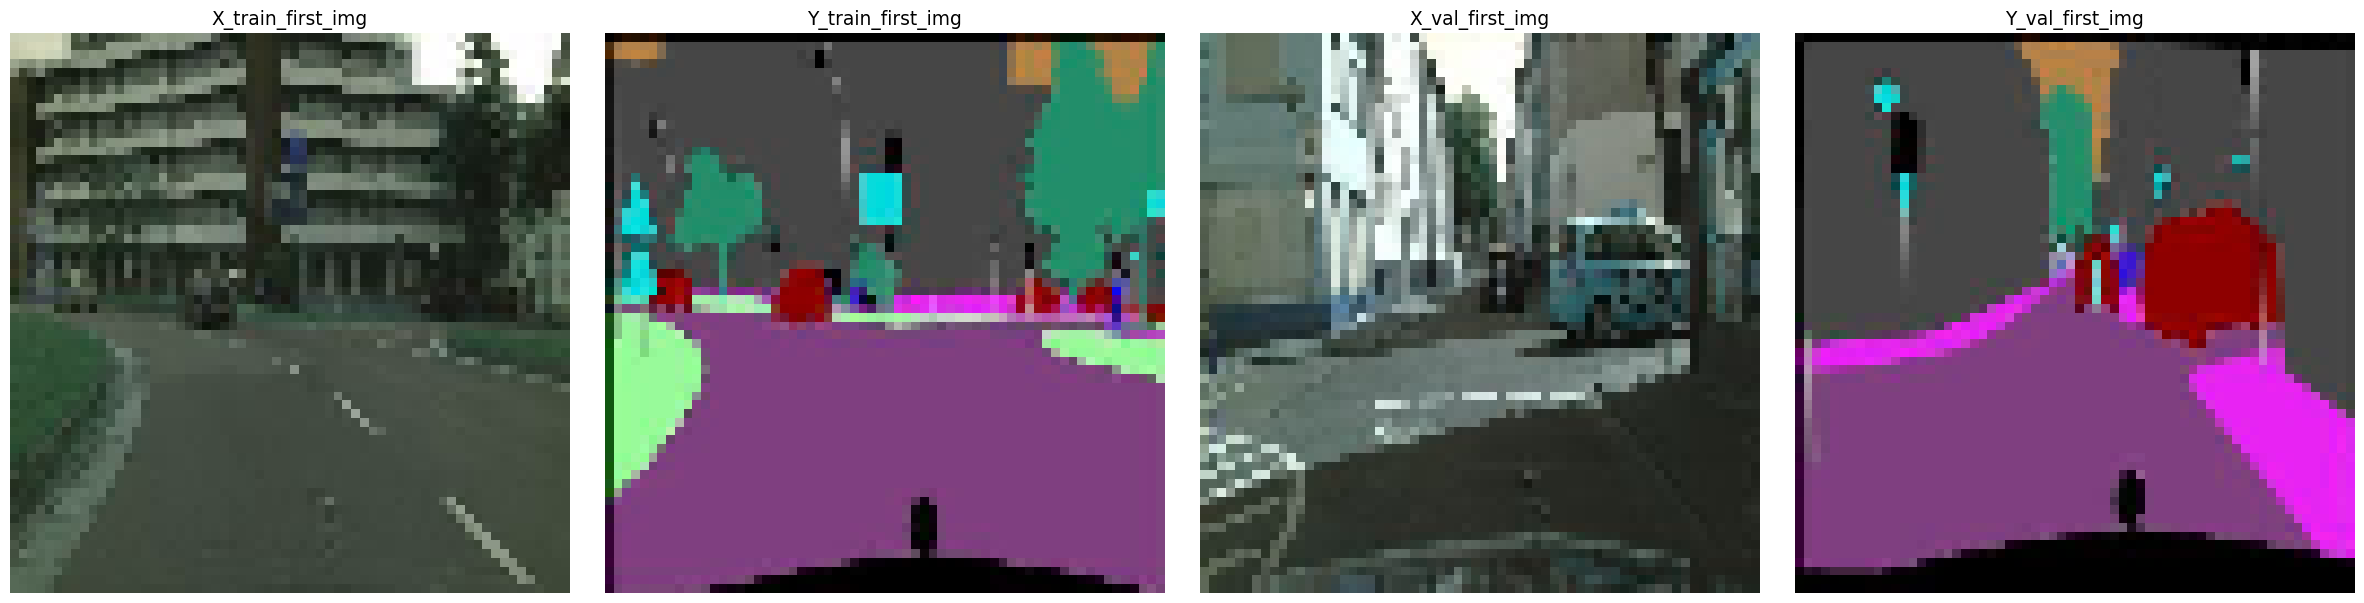

In [5]:
# 그리드 크기 설정
grid_size = (1, 4)

# 그리드 생성 및 이미지 표시
fig, axes = plt.subplots(*grid_size, figsize=(24, 6))

# X_train 이미지 표시
axes[0].imshow(X_train[0])
axes[0].axis('off')
axes[0].set_title('X_train_first_img')

# Y_train 이미지 표시
axes[1].imshow(Y_train[0])
axes[1].axis('off')
axes[1].set_title('Y_train_first_img')

# X_val 이미지 표시
axes[2].imshow(X_valid[0])
axes[2].axis('off')
axes[2].set_title('X_val_first_img')

# Y_val 이미지 표시
axes[3].imshow(Y_valid[0])
axes[3].axis('off')
axes[3].set_title('Y_val_first_img')

plt.tight_layout()
plt.show()

In [6]:
# 이미지 shape 출력
X_train = np.array(X_train)
Y_train = np.array(Y_train)
X_valid = np.array(X_valid)
Y_valid = np.array(Y_valid)

print(X_train.shape)
print(Y_train.shape)
print(X_valid.shape)
print(Y_valid.shape)

(2975, 64, 64, 3)
(2975, 64, 64, 3)
(500, 64, 64, 3)
(500, 64, 64, 3)


In [7]:
# 현 픽셀의 색상값과 가장 가까운 색상 라벨 인덱스를 리턴
def color_euclidian_dist(pixel):
    min_dist = 10000
    min_idx = 0
    for key, value in id_map.items():
        dist = (pixel[2] - value[0])**2 + (pixel[1] - value[1])**2 + (pixel[0] - value[2])**2
        if(dist <= min_dist):
            min_dist = dist
            min_idx = int(key)
    return min_idx

# 마스크 계산 함수
def calculate_mask(img):
    mask = np.zeros(shape=(row, col, 1), dtype=np.uint8)
    for r in range(row):
        for c in range(col):
            mask[r, c] = color_euclidian_dist(img[r, c])
    return mask

# 마스킹 함수
def mask_process(files):
    images = []
    for file in tqdm(files, desc="Masking label images"):
        img = calculate_mask(file)
        images.append(img)
    return images

# y(ground truth) 이미지들을 29개 클래스로 마스킹 작업 수행
# 마지막 채널 깊이가 1(0 ~ 29 가능)로 변함
# (n, row, col, 3) -> (n, row, col, 1)
Y_train_mask = mask_process(Y_train)
Y_valid_mask = mask_process(Y_valid)

Masking label images: 100%|██████████| 500/500 [01:06<00:00,  7.58it/s]


In [8]:
Y_train_mask = np.array(Y_train_mask)
Y_valid_mask = np.array(Y_valid_mask)

print(Y_train_mask.shape)
print(Y_valid_mask.shape)

(2975, 64, 64, 1)
(500, 64, 64, 1)


In [10]:
from light_unet import UNet
from tqdm import tqdm
from keras.losses import CategoricalCrossentropy
from keras.losses import SparseCategoricalCrossentropy
from keras.optimizers import Adam
from keras.optimizers.legacy import adam
from keras.metrics import MeanIoU
from keras.callbacks import ModelCheckpoint

img_size = (row, col)
model = UNet(img_size, num_classes)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 64, 64, 64)   1792        ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 64, 64, 64)   36928       ['conv2d[0][0]']                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 32, 32, 64)   0           ['conv2d_1[0][0]']               
                                                                                              

In [11]:
from keras.utils import to_categorical

# 256x256은 21.1GiB array를 담을 memory space가 필요해서 안됌
# 4번째 dim 깊이가 1인 y 마스크 자료형을 one_hot encoding
# (n, row, col, 1) -> (n, row, col, 29)
Y_train_mask_one_hot = to_categorical(Y_train_mask, num_classes=num_classes)
Y_valid_mask_one_hot = to_categorical(Y_valid_mask, num_classes=num_classes)

# 모델 선언
model.compile(optimizer=Adam(learning_rate = 0.0001), 
              loss=CategoricalCrossentropy(), 
              metrics=[MeanIoU(num_classes=num_classes)])
callbacks = [ModelCheckpoint('../model/semantic_segmentation_64.h5', save_best_only=True)]

In [12]:
print(Y_train_mask.shape)
print(Y_train_mask_one_hot.shape)
print(Y_valid_mask.shape)
print(Y_valid_mask_one_hot.shape)

(2975, 64, 64, 1)
(2975, 64, 64, 29)
(500, 64, 64, 1)
(500, 64, 64, 29)


In [13]:
# 모델 학습
history = model.fit(x=X_train, y=Y_train_mask_one_hot, epochs=40, batch_size=8, validation_data=(X_valid, Y_valid_mask_one_hot), callbacks=callbacks)

Epoch 1/40
372/372 [==============================] - 24s 52ms/step - loss: 10.7933 - mean_io_u: 0.4876 - val_loss: 2.6295 - val_mean_io_u: 0.4828
Epoch 2/40
372/372 [==============================] - 17s 45ms/step - loss: 2.4713 - mean_io_u: 0.4829 - val_loss: 2.2968 - val_mean_io_u: 0.4828
Epoch 3/40
372/372 [==============================] - 17s 45ms/step - loss: 1.8084 - mean_io_u: 0.4833 - val_loss: 1.7242 - val_mean_io_u: 0.4833
Epoch 4/40
372/372 [==============================] - 17s 45ms/step - loss: 1.5049 - mean_io_u: 0.4846 - val_loss: 1.3779 - val_mean_io_u: 0.4847
Epoch 5/40
372/372 [==============================] - 17s 45ms/step - loss: 1.3006 - mean_io_u: 0.4843 - val_loss: 1.2376 - val_mean_io_u: 0.4836
Epoch 6/40
372/372 [==============================] - 17s 45ms/step - loss: 1.1842 - mean_io_u: 0.4849 - val_loss: 1.1699 - val_mean_io_u: 0.4845
Epoch 7/40
372/372 [==============================] - 17s 45ms/step - loss: 1.1234 - mean_io_u: 0.4862 - val_loss: 1.1348 -

In [14]:
from keras.models import load_model

# 저장된 모델 불러오기
loaded_model = load_model('../model/semantic_segmentation_64.h5')

1/1 [==============================] - 1s 949ms/step


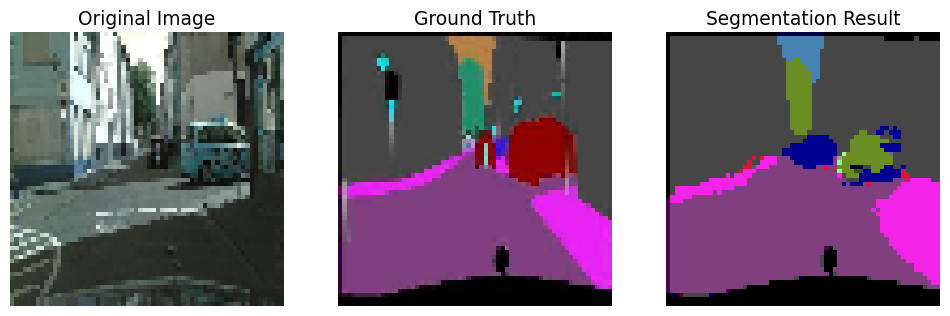

1/1 [==============================] - 0s 22ms/step


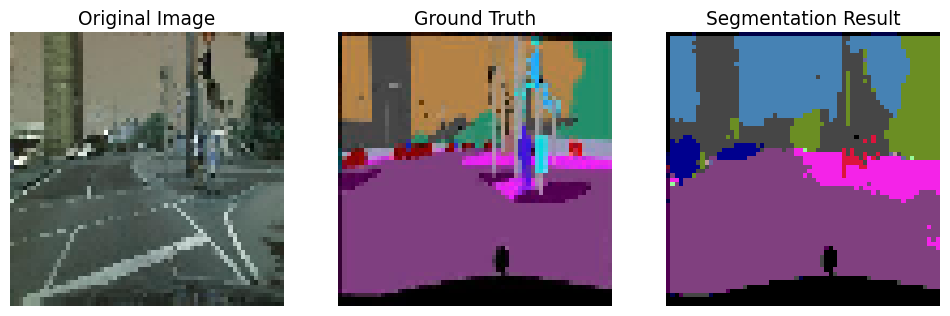

1/1 [==============================] - 0s 21ms/step


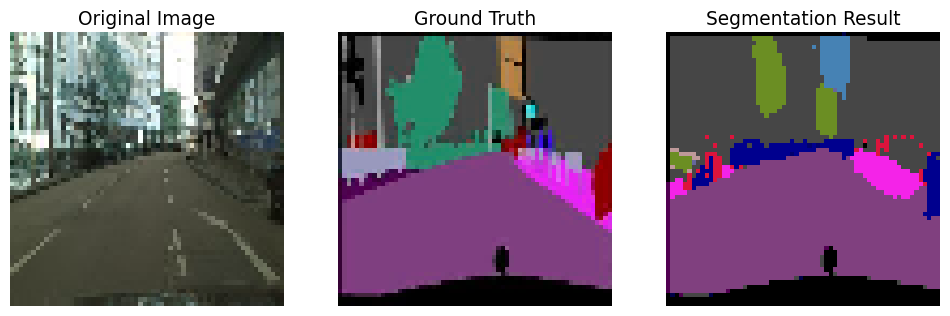

1/1 [==============================] - 0s 19ms/step


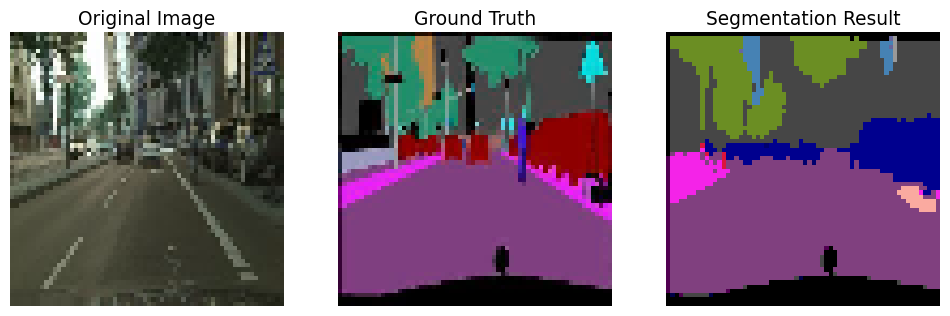

1/1 [==============================] - 0s 19ms/step


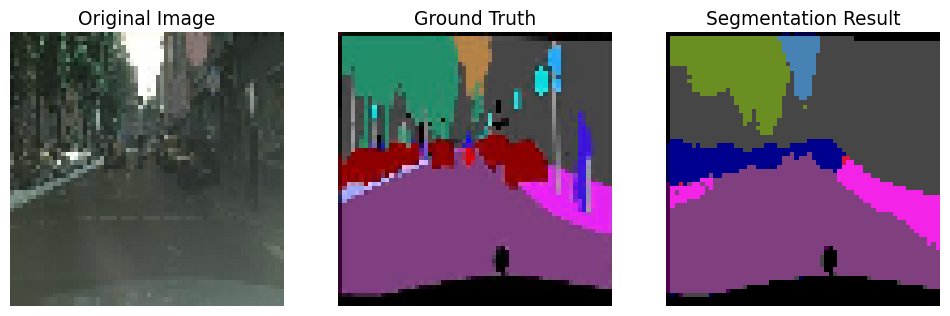

In [15]:
def prediction_plot(test_idx):
    # 검증 데이터 중 맨 첫 번째 이미지 선택
    input_image = X_valid[test_idx]
    gt_image = Y_valid[test_idx]

    # 모델을 사용하여 예측 수행
    predictions = loaded_model.predict(np.expand_dims(input_image, axis=0))

    # 매핑된 RGB 색상으로 이루어진 이미지 생성
    mapped_image = np.zeros((row, col, 3), dtype=np.uint8)

    for r in range(row):
        for c in range(col):
            label = np.argmax(predictions[0][r, c])  # 가장 높은 확률 값을 가진 라벨 선택        
            mapped_image[r, c] = id_map[label]     # id_map을 사용하여 RGB 색상으로 매핑

    # 원본 이미지와 예측 결과를 시각화
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 3, 1)
    plt.imshow(input_image)
    plt.title('Original Image')
    plt.axis('off')

    # Y_val 이미지 표시
    plt.subplot(1, 3, 2)
    plt.imshow(gt_image)
    plt.title('Ground Truth')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(mapped_image)
    plt.title('Segmentation Result')
    plt.axis('off')

    plt.show()

prediction_plot(0)
prediction_plot(100)
prediction_plot(200)
prediction_plot(300)
prediction_plot(400)

In [18]:
import cv2

# 동영상 파일 경로
video_path = 'C:/Users/daida/Desktop/DL_Project/data/video_test/sample1_64.mp4'

# 동영상 파일 열기
cap = cv2.VideoCapture(video_path)

# 출력 동영상 파일 경로 및 설정
output_path = 'C:/Users/daida/Desktop/DL_Project/data/video_test/sample1_64_segmented.mp4'
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_path, fourcc, 30.0, (col, row))  # 30.0은 프레임 속도입니다.

# Semantic Segmentation 모델 로드 (예: loaded_model)
loaded_model = load_model('../model/semantic_segmentation_256.h5')

while True:
    ret, frame = cap.read()
    if not ret:
        break
    
    # # 프레임 크기 조정 (row, col)로
    # frame = cv2.resize(frame, (col, row))
    
    # 모델에 입력으로 사용할 수 있도록 전처리
    input_frame = frame / 255.0  # 입력 프레임을 0에서 1 범위로 정규화
    input_frame = np.expand_dims(input_frame, axis=0)  # 모델은 배치 크기를 기대하므로 차원 추가
    
    # 모델에 프레임 적용 및 예측
    predictions = loaded_model.predict(input_frame)
    predicted_mask = np.argmax(predictions[0], axis=-1)
    
    # 예측된 마스크를 RGB 이미지로 매핑
    segmented_frame = np.zeros((row, col, 3), dtype=np.uint8)
    for r in range(row):
        for c in range(col):
            label = predicted_mask[r, c]
            segmented_frame[r, c] = id_map[label]
    
    # 출력 동영상에 프레임 추가
    out.write(segmented_frame)
    
# 동영상 파일 닫기
cap.release()
out.release()

# 창 닫기
cv2.destroyAllWindows()

1/1 [==============================] - 0s 27ms/step


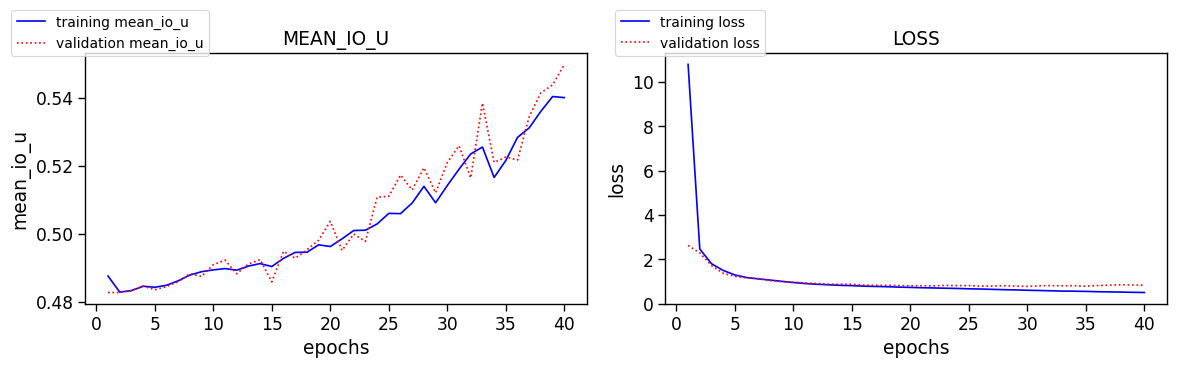

In [20]:
# 학습, 검증 정확도 출력

# 결과 시각화 함수
def vis(history, name):
    plt.title(f"{name.upper()}")
    plt.xlabel('epochs')
    plt.ylabel(f"{name.lower()}")
    value = history.history.get(name)
    val_value = history.history.get(f"val_{name}",None)
    epochs = range(1, len(value)+1)
    plt.plot(epochs, value, 'b-', label=f'training {name}')
    if val_value is not None :
        plt.plot(epochs, val_value, 'r:', label=f'validation {name}')
    plt.legend(loc='upper center', bbox_to_anchor=(0.05, 1.2) , fontsize=10 , ncol=1)

# 결과 출력
def plot_history(history):
    key_value = list(set([i.split("val_")[-1] for i in list(history.history.keys())]))
    plt.figure(figsize=(12, 4))
    for idx , key in enumerate(key_value) :
        plt.subplot(1, len(key_value), idx+1)
        vis(history, key)
    plt.tight_layout()
    plt.show()

plot_history(history)